# Homework 02 - Regression

In [371]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns

In [372]:
%matplotlib inline

## Preparing the Dataset

In [373]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv'
df = pd.read_csv(url)

In [374]:
df.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [375]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [376]:
base = [
    'ram',
    'storage',
    'screen',
    'final_price'
]

df = df[base]

In [377]:
df.head()

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


## EDA

Look at the final_price variable. Does it have a long tail?
- yes

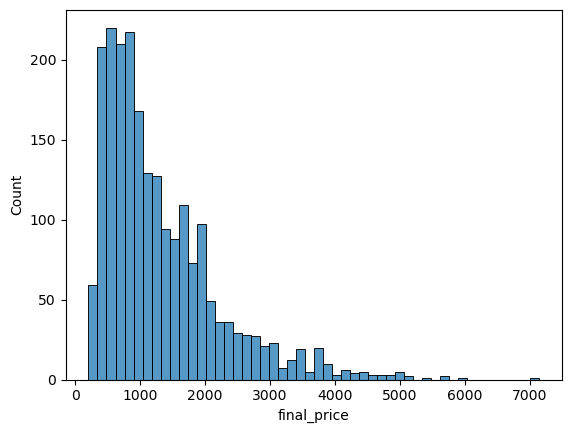

In [378]:
sns.histplot(df.final_price, bins=50)
plt.show()

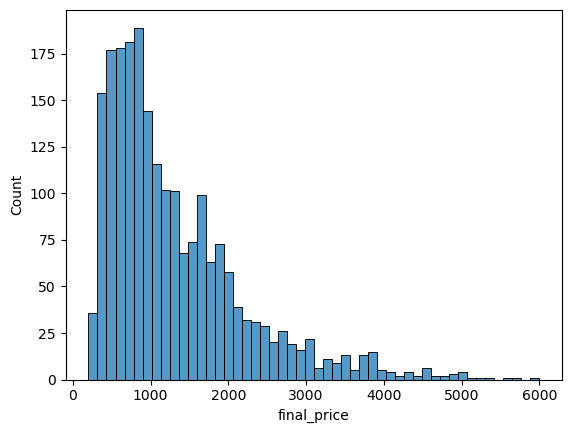

In [379]:
sns.histplot(df.final_price[df.final_price < 7000], bins=50)
plt.show()

In [380]:
price_log = np.log1p(df.final_price)

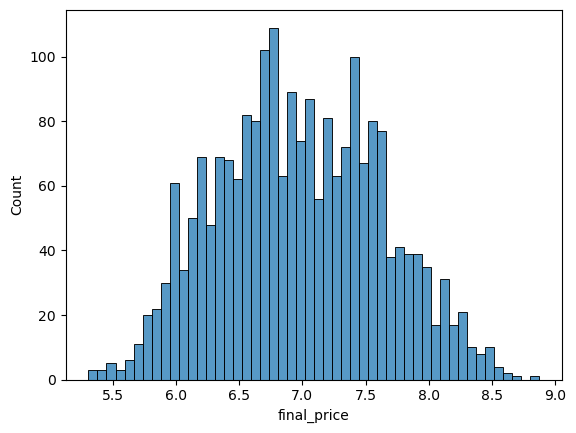

In [381]:
sns.histplot(price_log, bins=50)
plt.show()

## Question 1
There's one column with missing values. What is it?

- screen

In [382]:
df.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

## Question 2
What's the median (50% percentile) for variable 'ram'?

In [383]:
print(f' The median for variable ram is {int(df.ram.median())}.')

 The median for variable ram is 16.


## Prepare and split the dataset
- Shuffle the dataset (the filtered one you created above), use seed 42.
- Split your data in train/val/test sets, with 60%/20%/20% distribution.

In [384]:
n = len(df)

n_val = int(n * 0.2) # 20
n_test = int(n * 0.2) # 20
n_train = n - n_val - n_test # 60

n, n_val, n_test, n_train

(2160, 432, 432, 1296)

In [385]:
idx = np.arange(n)

np.random.seed(42) # setting seed to 42
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

In [386]:
df_train.head()

,ram,storage,screen,final_price
2079,32,1000,15.6,1123.29
668,4,64,14.1,201.05
2073,32,1000,14.0,997.74
1113,16,512,13.3,1016.00
788,32,1000,16.0,2739.00


In [387]:
len(df_train), len(df_val), len(df_test)

(1296, 432, 432)

In [388]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [389]:
y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

In [390]:
len(y_train)

1296

In [391]:
# drop target feature training, validation and test sets
del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

## Question 3
- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?

Options:
- With 0
- With mean
- **Both are equally good**


In [392]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [393]:
def prepare_X_0(df):
    df_0 = df.fillna(0)    
    X = df_0.values
    return X

In [394]:
def prepare_X_mean(df):
    df_mean = df.fillna(df.mean())    
    X = df_mean.values
    return X

In [395]:
def rmse(y, y_pred):
    error = y - y_pred
    mse = (error ** 2).mean()
    return np.sqrt(mse)

### Fill with 0

In [396]:
# train
X_train_0 = prepare_X_0(df_train)
w0, w = train_linear_regression(X_train_0, y_train)

In [397]:
# validation
X_val_0 = prepare_X_0(df_val)
y_pred_0 = w0 + X_val_0.dot(w)

In [398]:
print(rmse(y_val, y_pred_0).round(2))

597.36


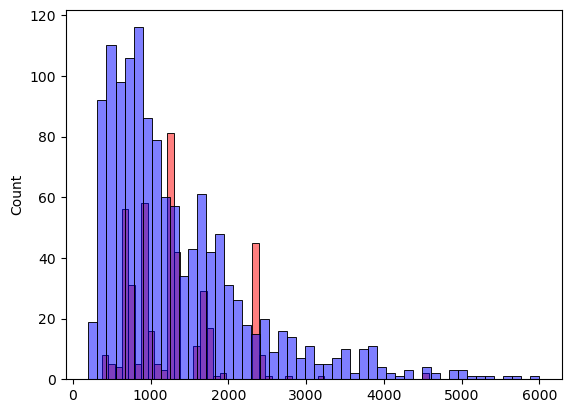

In [399]:
sns.histplot(y_pred_0, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)
plt.show()

### Fill the mean value

In [400]:
# train
X_train_mean = prepare_X_mean(df_train)
w0, w = train_linear_regression(X_train_mean, y_train)

In [401]:
# validation
X_val_mean = prepare_X_mean(df_val)
y_pred_mean = w0 + X_val_mean.dot(w)

In [402]:
print(rmse(y_val, y_pred_mean).round(2))

600.26


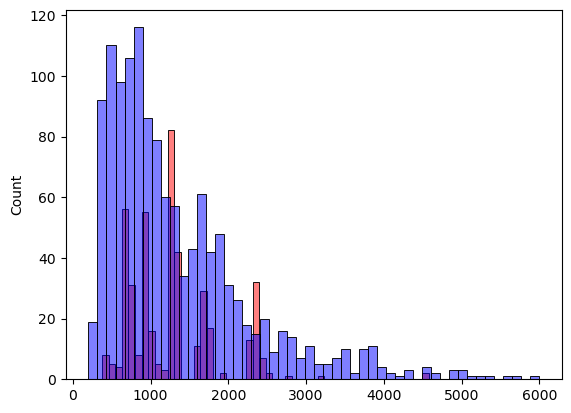

In [403]:
sns.histplot(y_pred_mean, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)
plt.show()

## Question 4
- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which r gives the best RMSE?

If there are multiple options, select the smallest r.

**smallest r: 0.01** but **1** is slightly better

In [404]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [405]:
# X_train = prepare_X_0(df_train)
# w0, w = train_linear_regression_reg(X_train, y_train, r=0.01)
# 
# X_val = prepare_X_0(df_val)
# y_pred = w0 + X_val.dot(w)
# rmse(y_val, y_pred)

In [408]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    X_train = prepare_X_0(df_train)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = prepare_X_0(df_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    
    print(r, w0, score.round(2))

0 676.8954853013648 597.36
0.01 676.2736817214528 597.36
0.1 670.7284836322351 597.35
1 619.9030834115337 597.21
5 463.7771697147013 597.01
10 352.7971336770988 597.06
100 66.92071440184108 597.9


## Question 5

- We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
- For each seed, do the train/validation/test split with 60%/20%/20% distribution.
- Fill the missing values with 0 and train a model without regularization.
- For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
- What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
- Round the result to 3 decimal digits (round(std, 3))


In [367]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores = []

n = len(df)
n_val = int(n * 0.2)  # 20% for validation
n_test = int(n * 0.2)  # 20% for test
n_train = n - n_val - n_test  # 60% for train

for seed in seeds:
    np.random.seed(seed)
    idx = np.arange(n)
    np.random.shuffle(idx)

    # Splitting data into train, validation, and test
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]

    # Reset indices
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    # Applying log1p transformation
    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values

    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']

    X_train = prepare_X_0(df_train)
    w0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_X_0(df_val)
    y_pred = w0 + X_val.dot(w)
    
    # Calculate RMSE
    score = rmse(y_val, y_pred)
    
    print(f'\n The score for the seed {seed} is: {round(score, 3)}')
    scores.append(score)

# Standard deviation of the exponential scores
std_dev = np.std(scores)
print(f'\nThe standard deviation of the scores is: {round(std_dev, 3)}')


 The score for the seed 0 is: 565.452

 The score for the seed 1 is: 636.799

 The score for the seed 2 is: 588.956

 The score for the seed 3 is: 597.815

 The score for the seed 4 is: 571.963

 The score for the seed 5 is: 573.238

 The score for the seed 6 is: 647.344

 The score for the seed 7 is: 550.44

 The score for the seed 8 is: 587.334

 The score for the seed 9 is: 576.102

The standard deviation of the scores is: 29.176


## Question 6
- Split the dataset like previously, use seed 9.
- Combine train and validation datasets.
- Fill the missing values with 0 and train a model with r=0.001.
- What's the RMSE on the test dataset?


In [368]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X) + r * np.eye(X.shape[1]) 
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [369]:
seed = 9
n = len(df)
n_test = int(n * 0.2) 
n_train = n - n_test  

np.random.seed(seed)
idx = np.arange(n)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_test = df.iloc[idx[n_train:]]

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.final_price.values
y_test = df_test.final_price.values

del df_train['final_price']
del df_test['final_price']

X_train = prepare_X_0(df_train)
w0, w = train_linear_regression_reg(X_train, y_train, r=0.001)

X_test = prepare_X_0(df_test)
y_pred_test = w0 + X_test.dot(w)

rmse_test = rmse(y_test, y_pred_test)
# result = np.expm1(rmse_test)

print(rmse_test)


608.6099822049604
